# Setup

In [ ]:
!pip install -q datasets
!pip install -q -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.0/224.0 kB 7.2 MB/s eta 0:00:00


# Lib

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, BatchNormalization, Identity, LeakyReLU, UpSampling2D
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy, SparseCategoricalCrossentropy

import datasets
from datasets import load_dataset, load_from_disk
from datasets.features import Image as ImageFeature

import albumentations as A

In [ ]:
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

from einops import repeat, rearrange, einsum, reduce
from einops.layers.tensorflow import Reduce, Rearrange

In [ ]:
import seaborn as sns
sns.set()

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth']=2

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [ ]:
seed=42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

# ENV

In [ ]:
anchors=[
    [(0.28, 0.22), (0.38, 0.48), (0.9, 0.78)],
    [(0.07, 0.15), (0.15, 0.11), (0.14, 0.29)],
    [(0.02, 0.03), (0.04, 0.07), (0.08, 0.06)]
]

In [ ]:
def pascal_iou(box1, box2):
    x1 = tf.maximum(box1[..., 0], box2[..., 0])
    y1 = tf.maximum(box1[..., 1], box2[..., 1])
    x2 = tf.minimum(box1[..., 2], box2[..., 2])
    y2 = tf.minimum(box1[..., 3], box2[..., 3])

    zero=tf.constant(0.0, dtype=box1.dtype)
    intersect = tf.maximum(zero, x2 - x1) * tf.maximum(zero, y2 - y1)

    box1_area = (box1[..., 2] - box1[..., 0]) * (box1[..., 3] - box1[..., 1])
    box2_area = (box2[..., 2] - box2[..., 0]) * (box2[..., 3] - box2[..., 1])

    union = box1_area + box2_area - intersect
    iou = intersect / union

    return iou

def yolo_to_pascal(box):
    x1 = box[..., 0]-box[..., 2]/2
    y1 = box[..., 1]-box[..., 3]/2
    x2 = box[..., 0]+box[..., 2]/2
    y2 = box[..., 1]+box[..., 3]/2
    return tf.stack([x1, y1, x2, y2], axis=-1)

def yolo_iou(box1, box2):
    box1 = yolo_to_pascal(box1)
    box2 = yolo_to_pascal(box2)
    return pascal_iou(box1, box2)

# Preprocessor

In [ ]:
import cv2

class ImageProcessor:
    def __init__(self, image_size):
        self.image_size=image_size
        self.test_transformer=A.Compose(
            [
                A.LongestMaxSize(max_size=image_size),
                A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT, value=0),
                A.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255)
            ],
            bbox_params=A.BboxParams(
                format='coco',
                min_visibility=0.4,
                label_fields=['labels']
            )
        )
        self.train_transformer=A.Compose(
            [
                A.LongestMaxSize(max_size=image_size),
                A.PadIfNeeded(min_height=image_size, min_width=image_size, border_mode=cv2.BORDER_CONSTANT, value=0),
                A.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5, p=0.5),
                A.HorizontalFlip(p=0.5),
                A.Normalize(mean=[0,0,0], std=[1,1,1], max_pixel_value=255),
            ],
            bbox_params=A.BboxParams(
                format='coco',
                min_visibility=0.4,
                label_fields=['labels']
            )
        )

    def train_transform(self, image, bboxes, labels):
        processed = self.train_transformer(image=image, bboxes=bboxes, labels=labels)
        return processed['image'],processed['bboxes'],processed['labels']

    def test_transform(self, image, bboxes, labels):
        processed = self.test_transformer(image=image, bboxes=bboxes, labels=labels)
        return processed['image'],processed['bboxes'],processed['labels']

    def coco_to_yolo_format(self, box):
        x,y,w,h = box

        x_center = x+w/2
        y_center = y+h/2

        x_center=x_center/self.image_size
        y_center=y_center/self.image_size
        width=w/self.image_size
        height=h/self.image_size

        return [x_center, y_center, width, height]

x=tf.random.uniform([224,224,3], minval=0, maxval=256)
bboxes=[[1,1,2,2]]
tmp=ImageProcessor(224)
tmp.test_transform(x.numpy(), bboxes, [2.0])
tmp.coco_to_yolo_format(bboxes[0])

[0.008928571428571428,
 0.008928571428571428,
 0.008928571428571428,
 0.008928571428571428]

# Ingestor

In [ ]:
import os
import json

class Ingestor:
    def __init__(self, save_dir='data', dataset_name='visual-layer/oxford-iiit-pet-vl-enriched'):
        self.save_dir=save_dir
        self.dataset_name=dataset_name
        self.prepare_dataset()
        self.prepare_mapping()

    def prepare_dataset(self):
        columns=['image', 'label_bbox_enriched']
        dataset=load_dataset(self.dataset_name).select_columns(columns).cast_column('image', ImageFeature(mode='RGB'))

        tmp=dataset['train'].train_test_split(train_size=0.99)
        dataset['validation']=tmp.pop('test')
        dataset['train']=tmp.pop('train')

        self.dataset=dataset.map(self.process_fn, batched=True, batch_size=1024, remove_columns='label_bbox_enriched')
        self.dataset.save_to_disk(self.save_dir)

    @staticmethod
    def process_fn(batch):
        target = [x if x is not None else [] for x in batch['label_bbox_enriched']]
        return {'label_bbox': target}

    def prepare_mapping(self):
        labels=[]
        for split in ['train', 'validation', 'test']:
            for sample in tqdm(self.dataset[split]):
                    labels.extend([box['label'] for box in sample['label_bbox']])

        labels=list(set(labels))
        label_to_id = {label:idx for idx, label in enumerate(labels)}
        id_to_label = {idx:label for idx, label in enumerate(labels)}

        with open(self.save_dir+'/label_to_id.json', 'w') as file:
            json.dump(label_to_id, file, indent=4)
        with open(self.save_dir+'/id_to_label.json', 'w') as file:
            json.dump(id_to_label, file, indent=4)

if os.path.exists('data')==False:
    tmp=Ingestor()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/5.91k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/149M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/133M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3669 [00:00<?, ? examples/s]

Map:   0%|          | 0/3643 [00:00<?, ? examples/s]

Map:   0%|          | 0/3669 [00:00<?, ? examples/s]

Map:   0%|          | 0/37 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3643 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/3669 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/37 [00:00<?, ? examples/s]

100%|██████████| 3669/3669 [00:07<00:00, 491.99it/s]


# Dataset

In [ ]:
class DataCollator:
    def __init__(self, image_size,label_to_id, anchors):
        self.processor=ImageProcessor(image_size)
        self.transform=self.processor.train_transform
        self.anchors = np.array(anchors).reshape(-1, 2)
        self.num_scale=3
        self.num_anchor_per_scale=3
        self.grid_sizes= [image_size//32, image_size//16, image_size//8]
        self.label_to_id=label_to_id
        self.iou_threshold=0.5

    def mode(self, split):
        if split=='train':
            self.transform=self.processor.train_transform
        else:
            self.transform=self.processor.test_transform

    def __call__(self, batch):
        processed = [self.single_process(x) for x in batch]
        image = [i[0] for i in processed]
        target_1 =[i[1] for i in processed]
        target_2 =[i[2] for i in processed]
        target_3 =[i[3] for i in processed]
        return {'image': image,
                'target_1': target_1,
                'target_2': target_2,
                'target_3': target_3,
                'label_bbox': np.array(len(batch))}

    def single_process(self, sample):
        image=sample['image']
        bboxes=[x['bbox'] for x in sample['label_bbox']]
        labels=[self.label_to_id[x['label']] for x in sample['label_bbox']]

        image, bboxes, labels = self.transform(image=image, bboxes=bboxes, labels=labels)
        targets=self.prepare_target(bboxes, labels)
        return image, *(targets)

    def prepare_target(self, bboxes, labels):
        bboxes=[self.processor.coco_to_yolo_format(box) for box in bboxes]
        targets = [np.zeros([self.num_anchor_per_scale, grid_size, grid_size, 6]) for grid_size in self.grid_sizes]

        for box, label in zip(bboxes, labels):
            iou_scores = self.iou(box[2:4], self.anchors)
            anchor_indices=np.argsort(iou_scores)[::-1]
            x,y,w,h = box

            has_anchor=[False]*self.num_scale
            for anchor_idx in anchor_indices:
                scale_idx = anchor_idx//self.num_anchor_per_scale
                anchor_on_scale = anchor_idx%self.num_anchor_per_scale

                grid_size=self.grid_sizes[scale_idx]
                i, j = int(y*grid_size), int(x*grid_size)
                anchor_taken = targets[scale_idx][anchor_on_scale,i,j,0]

                if not anchor_taken and not has_anchor[scale_idx]:
                    targets[scale_idx][anchor_on_scale, i, j, 0]=1

                    x_cell = grid_size*x-j
                    y_cell = grid_size*y-i
                    w_cell = grid_size*w
                    h_cell = grid_size*h
                    box_cell = [x_cell, y_cell, w_cell, h_cell]
                    targets[scale_idx][anchor_on_scale, i, j, 1:5] = box_cell
                    targets[scale_idx][anchor_on_scale, i, j, 5] = label
                    has_anchor[scale_idx] = True
                elif not anchor_taken and iou_scores[anchor_idx]>self.iou_threshold:
                    targets[scale_idx][anchor_on_scale, i, j, 0]=-1

        return targets

    @staticmethod
    def iou(box1, box2):
        intersection =np.minimum(box1[0], box2[..., 0]) * np.minimum(box1[1], box2[..., 1])
        box1_area = box1[0]*box1[1]
        box2_area = box2[..., 0]*box2[..., 1]

        union=box1_area+box2_area-intersection
        return intersection/union

class DataModule:
    def __init__(self,image_size=224,anchors=None, data_dir='data'):
        self.dataset=load_from_disk(data_dir)
        with open(data_dir+'/label_to_id.json', 'r') as file:
            self.label_to_id=json.load(file)
        with open(data_dir+'/id_to_label.json', 'r') as file:
            self.id_to_label=json.load(file)

        self.collator=DataCollator(image_size, self.label_to_id, anchors)

    def get_dataloader(self, split, batch_size=32, shuffle=False):
        self.collator.mode(split)
        return self.dataset[split].to_tf_dataset(columns=['image', 'label_bbox'], label_cols=['target_1','target_2','target_3'], collate_fn=self.collator,
                                                   batch_size=batch_size, drop_remainder=True, shuffle=shuffle, prefetch=tf.data.AUTOTUNE)

tmp=DataModule(anchors=anchors)
# tmp.prepare()
tmp.get_dataloader('validation', 4)

<_PrefetchDataset element_spec=({'image': TensorSpec(shape=(4, 224, 224, 3), dtype=tf.float32, name=None), 'label_bbox': TensorSpec(shape=(), dtype=tf.int64, name=None)}, {'target_1': TensorSpec(shape=(4, 3, 7, 7, 6), dtype=tf.float32, name=None), 'target_2': TensorSpec(shape=(4, 3, 14, 14, 6), dtype=tf.float32, name=None), 'target_3': TensorSpec(shape=(4, 3, 28, 28, 6), dtype=tf.float32, name=None)})>

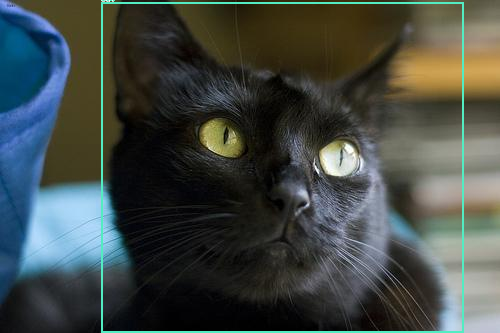

In [ ]:
from PIL import Image, ImageDraw, ImageFont

def draw_boxes(image, annotations):
    colors = {}
    draw = ImageDraw.Draw(image)
    for annotation in annotations:
        x_min, y_min, width, height = annotation['bbox']
        x_max=x_min+width
        y_max=y_min+height
        box=[x_min, y_min, x_max,y_max]
        label = annotation['label']

        if label not in colors:
            colors[label] = (random.randint(0, 255), random.randint(0, 255), random.randint(0, 255))

        color = colors[label]
        draw.rectangle(box, outline=color, width=2)

        text_position = (box[0], box[1] - 10)
        font = ImageFont.load_default()

        text_bbox = font.getbbox(label)
        text_width = text_bbox[2] - text_bbox[0]
        text_height = text_bbox[3] - text_bbox[1]

        draw.rectangle(
            [text_position, (text_position[0] + text_width, text_position[1] + text_height)],
            fill=color
        )
        draw.text(text_position, label, fill=(255, 255, 255), font=font)

    return image

data=tmp.dataset['validation'][0]
result_image = draw_boxes(data['image'], data['label_bbox'])
result_image

# Architecture

In [ ]:
class CNNBlock(tf.keras.Layer):
    def __init__(self, out_channels, kernel_size=3, strides=1, padding='valid', use_bn=True):
        super().__init__()
        self.net=tf.keras.Sequential([
            Conv2D(out_channels,kernel_size=kernel_size, strides=strides, padding=padding, use_bias=not use_bn),
            BatchNormalization() if use_bn else Identity(),
            LeakyReLU(negative_slope=0.1) if use_bn else Identity(),
        ])

    def call(self,x):
        return self.net(x)

x=tf.random.normal([7,224,224,3])
tmp=CNNBlock(6)
tmp(x).shape

TensorShape([7, 222, 222, 6])

In [ ]:
class ResidualBlock(tf.keras.layers.Layer):
    def __init__(self, channels, use_residual=True, num_repeats=1):
        super(ResidualBlock, self).__init__()
        self.layers = []
        for _ in range(num_repeats):
            block = tf.keras.Sequential([
                Conv2D(channels//2, kernel_size=1, padding='same'),
                BatchNormalization(),
                LeakyReLU(negative_slope=0.1),
                Conv2D(channels, kernel_size=3, padding='same'),
                BatchNormalization(),
                LeakyReLU(negative_slope=0.1)
            ])
            self.layers.append(block)
        self.use_residual = use_residual
        self.num_repeats=num_repeats

    def call(self, x):
        for layer in self.layers:
            x = x + layer(x) if self.use_residual else layer(x)

        return x

x=tf.random.normal([1,416,416,2])
tmp=ResidualBlock(2)
tmp(x).shape

TensorShape([1, 416, 416, 2])

In [ ]:
class ScalePrediction(tf.keras.Layer):
    def __init__(self, channels, num_classes):
        super().__init__()
        self.net=tf.keras.Sequential([
            Conv2D(2*channels, kernel_size=3, padding='same'),
            BatchNormalization(),
            LeakyReLU(negative_slope=0.1),
            Conv2D((num_classes+5)*3, kernel_size=1)
        ])
        self.num_classes=num_classes

    def call(self, x):
        out=self.net(x)
        out=rearrange(out,'b w h (n_box n_feature) -> b n_box w h n_feature', n_feature=self.num_classes+5)
        return out

x=tf.random.normal([1,416,416,6])
tmp=ScalePrediction(6,2)
tmp(x).shape

TensorShape([1, 3, 416, 416, 7])

In [ ]:
class YOLOv3(tf.keras.Model):
    def __init__(self, channels, num_classes):
        super().__init__()
        self.layer_list=[
            CNNBlock(32, kernel_size=3, strides=1, padding='same'),
            CNNBlock(64, kernel_size=3, strides=2, padding='same'),
            ResidualBlock(64, num_repeats=1),

            CNNBlock(128, kernel_size=3, strides=2, padding='same'),
            ResidualBlock(128, num_repeats=1),

            CNNBlock(256, kernel_size=3, strides=2, padding='same'),
            ResidualBlock(256, num_repeats=2),

            CNNBlock(512, kernel_size=3, strides=2, padding='same'),
            ResidualBlock(512, num_repeats=2),

            CNNBlock(1024, kernel_size=3, strides=2, padding='same'),
            ResidualBlock(1024, num_repeats=1),

            CNNBlock(512, kernel_size=1, strides=1, padding='valid'),
            CNNBlock(1024, kernel_size=3, strides=1, padding='same'),
            ResidualBlock(1024, use_residual=False, num_repeats=1),

            CNNBlock(512, kernel_size=1, strides=1, padding='valid'),
            ScalePrediction(512, num_classes=num_classes),

            CNNBlock(256, kernel_size=1, strides=1, padding='valid'),
            UpSampling2D((2,2)),

            CNNBlock(256, kernel_size=1, strides=1, padding='valid'),
            CNNBlock(512, kernel_size=3, strides=1, padding='same'),
            ResidualBlock(512, use_residual=False, num_repeats=1),


            CNNBlock(256, kernel_size=1, strides=1, padding='valid'),
            ScalePrediction(256, num_classes=num_classes),

            CNNBlock(128, kernel_size=1, strides=1, padding='valid'),
            UpSampling2D((2,2)),

            CNNBlock(128, kernel_size=1, strides=1, padding='valid'),
            CNNBlock(256, kernel_size=3, strides=1, padding='same'),
            ResidualBlock(256, use_residual=False, num_repeats=1),

            CNNBlock(128, kernel_size=1, strides=1, padding='valid'),
            ScalePrediction(128, num_classes=num_classes)
        ]

    def call(self,x):
        outputs=[]
        route_connections=[]
        for i, layer in enumerate(self.layer_list):
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue
            x=layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats==2:
                route_connections.append(x)
            elif isinstance(layer, UpSampling2D):
                x=tf.concat([x, route_connections[-1]], axis=-1)
                route_connections.pop()

        return outputs


x=tf.random.normal([7,224,224,3])
tmp=YOLOv3(3,2)
res=tmp(x)
for i in res:
    print(i.shape)

(7, 3, 7, 7, 7)
(7, 3, 14, 14, 7)
(7, 3, 28, 28, 7)


In [ ]:
class YOLOMiniv1(tf.keras.Model):
    def __init__(self, channels, num_classes):
        super().__init__()
        self.layer_list=[
            CNNBlock(2, kernel_size=3, strides=2, padding='same'),
            CNNBlock(4, kernel_size=3, strides=2, padding='same'),
            CNNBlock(8, kernel_size=3, strides=2, padding='same'),
            ResidualBlock(8, num_repeats=1),

            CNNBlock(16, kernel_size=3, strides=2, padding='same'),
            ResidualBlock(16, num_repeats=1),

            CNNBlock(32, kernel_size=3, strides=2, padding='same'),
            ScalePrediction(1, num_classes=num_classes),

            UpSampling2D((2,2)),
            ScalePrediction(1, num_classes=num_classes),

            UpSampling2D((2,2)),
            ScalePrediction(1, num_classes=num_classes)
        ]

    def call(self,x):
        outputs=[]
        route_connections=[]
        for i, layer in enumerate(self.layer_list):
            if isinstance(layer, ScalePrediction):
                outputs.append(layer(x))
                continue
            x=layer(x)

            if isinstance(layer, ResidualBlock) and layer.num_repeats==1:
                route_connections.append(x)
            elif isinstance(layer, UpSampling2D):
                x=tf.concat([x, route_connections[-1]], axis=-1)
                route_connections.pop()

        return outputs


x=tf.random.normal([7,224,224,3])
tmp=YOLOv3(3,2)
res=tmp(x)
for i in res:
    print(i.shape)

(7, 3, 7, 7, 7)
(7, 3, 14, 14, 7)
(7, 3, 28, 28, 7)


In [ ]:
class YOLOMiniv2(tf.keras.Model):
    def __init__(self, channels, num_classes):
        super().__init__()

        self.net_1=Conv2D((num_classes+5)*3, kernel_size=3, strides=32, padding='same')
        self.net_2=Conv2D((num_classes+5)*3, kernel_size=3, strides=16, padding='same')
        self.net_3=Conv2D((num_classes+5)*3, kernel_size=3, strides=8, padding='same')
        self.num_classes=num_classes

    def call(self,x):
        x1 = tf.reshape(self.net_1(x), [-1,3,7,7,self.num_classes+5])
        x2 = tf.reshape(self.net_2(x), [-1,3,14,14,self.num_classes+5])
        x3 = tf.reshape(self.net_3(x), [-1,3,28,28,self.num_classes+5])

        return x1,x2,x3
# (7, 3, 7, 7, 7)
# (7, 3, 14, 14, 7)
# (7, 3, 28, 28, 7)
x=tf.random.normal([7,224,224,3])
tmp=YOLOv3(3,3)
res=tmp(x)
for i in res:
    print(i.shape)

(7, 3, 7, 7, 8)
(7, 3, 14, 14, 8)
(7, 3, 28, 28, 8)


# Loss

In [ ]:
class YOLOLoss(tf.keras.losses.Loss):
    def __init__(self, reduction='sum_over_batch_size'):
        super().__init__(reduction=reduction)
        self.lambda_class=1
        self.lambda_obj=1
        self.lambda_noobj=1
        self.lambda_coord=1
        self.anchors=tf.convert_to_tensor(anchors)

        self.mse=tf.keras.losses.MeanSquaredError()
        self.bce=tf.keras.losses.BinaryCrossentropy(from_logits=True)
        self.ce=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, target, pred):
        loss=0.0
        for idx, val in enumerate(target.values()):
            loss=loss+self.single_loss(val, pred[idx], self.anchors[idx])

        return loss

    def single_loss(self, target, pred, anchors):
        anchors=tf.cast(anchors, pred.dtype)
        obj = target[..., 0]==1
        noobj = target[..., 0]==0

        # no object loss
        noobj_loss= self.bce(target[..., 0][noobj], pred[..., 0][noobj])

        # obj loss
        anchors = tf.reshape(anchors,[1,3,1,1,2])
        pred_boxes = tf.concat([tf.math.sigmoid(pred[...,1:3]), tf.math.exp(pred[..., 3:5])*anchors], axis=-1)
        iou_score = yolo_iou(pred_boxes[obj], target[..., 1:5][obj])
        obj_loss=self.bce(iou_score*target[..., 0][obj], pred[..., 0][obj])

        # box loss
        pred_boxes = tf.concat([tf.math.sigmoid(pred[..., 1:3]), pred[..., 3:5]], axis=-1)
        true_boxes = tf.concat([pred[..., 1:3], tf.math.log(1e-6+ target[..., 3:5]/anchors)], axis=-1)
        coord_loss = self.mse(true_boxes[obj], pred_boxes[obj])

        # class loss
        class_loss = self.ce(target[..., 5:][obj], pred[..., 5:][obj])

        return self.lambda_noobj*noobj_loss + self.lambda_obj*obj_loss + self.lambda_coord*coord_loss + self.lambda_class*class_loss

# PostProcess

In [ ]:
def get_pred_boxes(pred, anchors, grid_size, obj_threshold):
    obj_pred=pred[..., 0:1]
    center_pred=pred[..., 1:3]
    size_pred=pred[..., 3:5]*tf.reshape(anchors, [1, len(anchors), 1, 1, 2])
    best_prob = tf.math.reduce_max(tf.nn.softmax(pred[..., 5:], axis=-1), axis=-1, keepdims=True)
    best_class = tf.cast(tf.expand_dims(tf.math.argmax(pred[..., 5:], axis=-1), -1), dtype=pred.dtype)

    cell_indices=repeat(tf.range(grid_size, dtype=pred.dtype), 'h -> 1 a h w 1', a=len(anchors), w=grid_size)
    x=1/grid_size*(center_pred[..., 0:1]+cell_indices)
    y=1/grid_size*(center_pred[..., 1:2]+rearrange(cell_indices, 'b a h w 1 -> b a w h 1'))
    wh=1/grid_size*size_pred

    pred_boxes = tf.concat([obj_pred, x, y, wh, best_class, best_prob], axis=-1)
    filtered_boxes = []
    for batch in pred_boxes:
        filtered = tf.boolean_mask(batch, batch[..., 0] >= obj_threshold)
        filtered_boxes.append(filtered[..., 1:])
    return filtered_boxes # batch, box of batch, 7

pred=tf.random.normal([7,3,14,14,200])
get_pred_boxes(pred, anchors[0] ,14,0.5).__len__()

7

In [ ]:
def get_true_boxes(target, anchors, grid_size):
    # boxes = batch_size, anchor, s ,s 6
    # box = [obj, x ,y, w ,h, class_idx]
    center = target[..., 1:3]
    size = target[..., 3:5]
    label_idx= target[..., 5:6]

    cell_indices=repeat(tf.range(grid_size, dtype=tf.float32), 'h -> 1 a h w 1', a=len(anchors), w=grid_size)
    x=1/grid_size*(center[..., 0:1]+cell_indices)
    y=1/grid_size*(center[..., 1:2]+rearrange(cell_indices, 'b a h w 1 -> b a w h 1'))
    wh=1/grid_size*size
    true_boxes=tf.concat([x,y,wh, label_idx], axis=-1)
    filtered_boxes = []
    for batch in true_boxes:
        filtered = tf.boolean_mask(batch, batch[..., 0] ==1)
        filtered_boxes.append(filtered[..., 1:])
    return filtered_boxes

x=tf.random.normal([7,3,14,14,200])
get_true_boxes(x,anchors[0],14).__len__()

7

In [ ]:
@tf.function
def nms(boxes, iou_threshold=0.5, obj_threshold=0.5, class_threshold=0.5):
    # Apply thresholds
    boxes = tf.boolean_mask(boxes, (boxes[:, 5] > class_threshold) & (boxes[:, 0] > obj_threshold))

    # Sort boxes by class probability (5th index)
    sorted_indices = tf.argsort(boxes[:, 5], direction='DESCENDING')
    boxes = tf.gather(boxes, sorted_indices)

    selected_indices = tf.TensorArray(tf.int32, size=0, dynamic_size=True)  # Use TensorArray to collect indices
    mark = tf.ones(tf.shape(boxes)[0], dtype=tf.bool)
    while tf.reduce_sum(tf.cast(mark, tf.int32)) != 0:
        # Get the index of the first True mark
        idx = tf.where(mark)[0][0]
        selected_indices = selected_indices.write(selected_indices.size(), sorted_indices[idx])  # Store the original index

        # Mark the selected box as False
        mark = tf.tensor_scatter_nd_update(mark, [[idx]], [False])

        selected_box = boxes[idx]

        # Update marks for boxes with the same class that have IoU above the threshold
        for i in tf.range(tf.shape(boxes)[0]):
            if mark[i]:
                if boxes[i][4] == selected_box[4]:  # Same class
                    iou = yolo_iou(selected_box[0:4], boxes[i][0:4])
                    if iou < iou_threshold:
                        mark = tf.tensor_scatter_nd_update(mark, [[i]], [False])

    # Convert TensorArray to tensor
    selected_indices_tensor = selected_indices.stack()
    # Gather selected boxes using their original indices
    return tf.gather(boxes, selected_indices_tensor)

In [ ]:
def mean_average_precision(true_boxes,pred_boxes, iou_thresholds=[0.5], prob_thresholds=[0.5], num_classes=20):
    # box = [[x1,y1,x2,y2,calss_idx,prob]]

    TP=np.zeros([num_classes, len(iou_thresholds), len(prob_thresholds)])
    FP=np.zeros([num_classes, len(iou_thresholds), len(prob_thresholds)])
    num_true_boxes = np.zeros([num_classes])
    for single_pred_boxes, single_true_boxes in zip(pred_boxes, true_boxes):
        single_pred_boxes=sorted(single_pred_boxes, key = lambda x: x[5], reverse=True)
        for true_box in single_true_boxes:
            num_true_boxes[int(true_box[4])] += 1

        matched = [False]*len(single_true_boxes)
        for pred_box in single_pred_boxes:
            best_score=0
            best_idx=0
            for idx, true_box in enumerate(single_true_boxes):
                iou_score = yolo_iou(pred_box[0:4], true_box[0:4])
                if iou_score>best_score and pred_box[4]==true_box[4]:
                    best_score=iou_score
                    best_idx=idx

            for iou_idx, iou_threshold in enumerate(iou_thresholds):
                for prob_idx, prob_threshold in enumerate(prob_thresholds):
                    if best_score>iou_threshold and pred_box[5]>=prob_threshold:
                        if matched[best_idx]==False:
                            TP[pred_box[4]][iou_idx][prob_idx]+=1
                            matched[best_idx]=True
                        else:
                            FP[pred_box[4]][iou_idx][prob_idx]+=1

    return TP, FP, num_true_boxes

In [ ]:
class Metrics(tf.keras.Metric):
    def __init__(self, anchors, grid_sizes=None):
        super().__init__()
        self.anchors=anchors
        self.grid_sizes=grid_sizes

        self.maPR_iou_thresholds=[0.0, 0.075]
        self.maPR_class_thresholds=[0.0, 0.075]

    def get_single_scale_metrics(self, pred, target, anchor, grid_size):
        true_boxes=get_true_boxes(target, anchor, grid_size)
        pred_boxes=get_pred_boxes(pred, anchor, grid_size, obj_threshold=0.05)
        pred_boxes=[nms(batch, iou_threshold=0.05, obj_threshold=0.05, class_threshold=0.05) for batch in pred_boxes]
        metrics=mean_average_precision(pred_boxes, true_boxes, iou_thresholds=self.maPR_iou_thresholds,
                                       prob_thresholds=self.maPR_class_thresholds, num_classes=208)
        return metrics

    def get_metrics(self, target, pred):
        TP, FP, num_true_boxes = [], [], []
        for idx, val in enumerate(target.values()):
            res = self.get_single_scale_metrics(val, pred[idx], self.anchors[idx], val.shape[2])
            TP.append(res[0])
            FP.append(res[1])
            num_true_boxes.append(res[2])

        TP=sum(TP)
        FP=sum(FP)
        num_true_boxes=sum(num_true_boxes)
        return self.calculate_metrics(TP, FP, num_true_boxes)

    def calculate_metrics(self, TP, FP, num_true_boxes):
        precision = np.divide(TP, TP + FP, out=np.zeros_like(TP), where=(TP + FP) != 0)
        precision = np.mean(precision, axis=0)
        recall = np.divide(TP, num_true_boxes[:, None, None], out=np.zeros_like(TP), where=num_true_boxes[:, None, None] != 0)
        recall = np.mean(recall, axis=0)

        metrics={}
        for iou_idx, iou_threshold in enumerate(self.maPR_iou_thresholds):
            for prob_idx, prob_threshold in enumerate(self.maPR_class_thresholds):
                key=f'iou@{iou_threshold}_prob@{prob_threshold}'
                metrics['Precision_'+key]=precision[iou_idx][prob_idx]
                metrics['Recall_'+key]=recall[iou_idx][prob_idx]

        return metrics.values()

# Single

In [ ]:
from types import SimpleNamespace

class Trainer:
    def __init__(self, data_module, model_config, training_config):
        self.train_dataset = data_module.get_dataloader('train',batch_size=training_config.batch_size)
        self.val_dataset = data_module.get_dataloader('validation',batch_size=training_config.batch_size)
        self.test_dataset = data_module.get_dataloader('test',batch_size=training_config.batch_size)

        self.training_config=training_config
        self.model = YOLOv3(model_config.in_channels,model_config.num_classes)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = training_config.learning_rate)
        self.loss_fn = YOLOLoss()

    def train(self):
        num_train_step = tf.data.experimental.cardinality(self.train_dataset).numpy()
        num_val_step = tf.data.experimental.cardinality(self.val_dataset).numpy()

        for epoch in range(self.training_config.num_epochs):
            print(f'Epoch {epoch+1}/{self.training_config.num_epochs}')
            pbar = tf.keras.utils.Progbar(target=int(num_train_step), stateful_metrics=['loss', 'val_loss'])
            metrics = {}
            for step, batch in enumerate(self.train_dataset):
                with tf.GradientTape() as tape:
                    pred = self.model(batch[0]['image'], training=True)
                    loss = self.loss_fn(batch[1], pred)

                print(the_metrics.get_metrics(batch[1], pred))
                grads=tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))


                metrics.update({'loss': loss.numpy()})
                pbar.update(step+1, values=metrics.items(), finalize=False)

            for batch in self.val_dataset:
                pred = self.model(batch[0]['image'])
                loss = self.loss_fn(batch[1], pred)
                metrics.update({'val_loss': loss.numpy()})

            pbar.update(num_train_step, values=metrics.items(), finalize=True)

        self.model.save('yolov3.keras')
        tf.saved_model.save(self.model, 'saved_model/yolov3')

# training_config=SimpleNamespace(learning_rate=1e-5,num_epochs=2,batch_size=64)
# model_config=SimpleNamespace(in_channels=3, num_classes=208)
# tmp=Trainer(DataModule(anchors=anchors), model_config, training_config)
# the_metrics=Metrics(anchors)
tmp.train()

Epoch 1/2
dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 1/56 ━━━━━━━━━━━━━━━━━━━━ 11:59 13s/step - loss: 13.4364dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 2/56 ━━━━━━━━━━━━━━━━━━━━ 3:32 4s/step - loss: 12.8181  dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 3/56 ━━━━━━━━━━━━━━━━━━━━ 3:38 4s/step - loss: 11.3220dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 4/56 ━━━━━━━━━━━━━━━━━━━━ 3:35 4s/step - loss: 11.9990dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 5/56 ━━━━━━━━━━━━━━━━━━━━ 3:27 4s/step - loss: 12.2788dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 6/56 ━━━━━━━━━━━━━━━━━━━━ 3:23 4s/step - loss: 11.8531dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 7/56 ━━━━━━━━━━━━━━━━━━━━ 3:22 4s/step - loss: 12.0003dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 8/56 ━━━━━━━━━━━━━━━━━━━━ 3:17 4s/step - loss: 12.8503dict_values([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
 9/56 ━━━━━━━━━━━━━━━━━━━━ 3:13 4s/step - loss: 13.9374dict_

# Dist Normal

In [ ]:
from types import SimpleNamespace

class Trainer:
    def __init__(self, data_module, model_config, training_config):
        self.train_dataset = data_module.get_dataloader('train',batch_size=training_config.batch_size)
        self.val_dataset = data_module.get_dataloader('validation',batch_size=training_config.batch_size)
        self.test_dataset = data_module.get_dataloader('test',batch_size=training_config.batch_size)

        if len(tf.config.list_physical_devices('GPU')) > 1:
            self.strategy = tf.distribute.MirroredStrategy()
        elif len(tf.config.list_physical_devices('GPU')) == 1:
            self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        else:
            self.strategy = tf.distribute.get_strategy()

        self.training_config=training_config
        with self.strategy.scope():
            self.model = YOLOMiniv2(model_config.in_channels,model_config.num_classes)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate = training_config.learning_rate)

            self.loss_fn = YOLOLoss(reduction = tf.keras.losses.Reduction.NONE)
            self.train_dist_dataset = self.strategy.experimental_distribute_dataset(self.train_dataset)
            self.val_dist_dataset = self.strategy.experimental_distribute_dataset(self.val_dataset)
            self.test_dist_dataset = self.strategy.experimental_distribute_dataset(self.test_dataset)

    def train(self):
        def forward(X, y, training=False):
            pred = self.model(X, training=training)
            loss = self.loss_fn(y, pred)
            loss = tf.reduce_sum(loss) * (1.0/self.training_config.batch_size)
            return loss, pred

        @tf.function
        def train_step(dist_inputs):
            def step_fn(inputs):
                X, y = inputs
                with tf.GradientTape() as tape:
                    loss, pred = forward(X['image'], y, training=True)

                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                return loss

            return _compute_metrics(step_fn, dist_inputs)

        @tf.function
        def val_step(dist_inputs):
            def step_fn(inputs):
                X, y = inputs
                loss, pred = forward(X['image'], y, training=False)
                return loss

            return _compute_metrics(step_fn, dist_inputs)

        @tf.function
        def _compute_metrics(step_fn, dist_inputs):
            per_replica_loss = self.strategy.run(step_fn, args=(dist_inputs,))
            total_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
            mean_loss = total_loss / tf.cast(self.training_config.batch_size, total_loss.dtype)
            return mean_loss

        with self.strategy.scope():
            num_train_step = tf.data.experimental.cardinality(self.train_dist_dataset).numpy()
            num_val_step = tf.data.experimental.cardinality(self.val_dist_dataset).numpy()

            for epoch in range(self.training_config.num_epochs):
                print(f'Epoch {epoch+1}/{self.training_config.num_epochs}')
                pbar = tf.keras.utils.Progbar(target=int(num_train_step), stateful_metrics=['loss'])
                metrics = {}
                for step, batch in enumerate(self.train_dist_dataset):
                    loss = train_step(batch)
                    metrics.update({'loss': loss.numpy()})
                    pbar.update(step+1, values=metrics.items(), finalize=False)

                for batch in self.val_dist_dataset:
                    loss = val_step(batch)
                    metrics.update({'val_loss': loss.numpy()})

                pbar.update(num_train_step, values=metrics.items(), finalize=True)

        self.model.save('yolov3.keras')
        tf.saved_model.save(self.model, 'saved_model/yolov3')

training_config=SimpleNamespace(learning_rate=1e-5,num_epochs=2,batch_size=4)
model_config=SimpleNamespace(in_channels=3, num_classes=208)
tmp=Trainer(DataModule(anchors=anchors), model_config, training_config)
tmp.train()

Epoch 1/2
131/910 ━━━━━━━━━━━━━━━━━━━━ 7:24 571ms/step - loss: 19.5000

KeyboardInterrupt: 

# Dist float16

In [ ]:
from types import SimpleNamespace

class Trainer:
    def __init__(self, data_module, model_config, training_config):
        tf.keras.backend.set_floatx('float16')

        self.train_dataset = data_module.get_dataloader('train',batch_size=training_config.batch_size)
        self.val_dataset = data_module.get_dataloader('validation',batch_size=training_config.batch_size)
        self.test_dataset = data_module.get_dataloader('test',batch_size=training_config.batch_size)

        if len(tf.config.list_physical_devices('GPU')) > 1:
            self.strategy = tf.distribute.MirroredStrategy()
        elif len(tf.config.list_physical_devices('GPU')) == 1:
            self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        else:
            self.strategy = tf.distribute.get_strategy()

        self.training_config=training_config
        with self.strategy.scope():
            self.model = YOLOMiniv2(model_config.in_channels,model_config.num_classes)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate = training_config.learning_rate)

            self.loss_fn = YOLOLoss(reduction = tf.keras.losses.Reduction.NONE)
            self.train_dist_dataset = self.strategy.experimental_distribute_dataset(self.train_dataset)
            self.val_dist_dataset = self.strategy.experimental_distribute_dataset(self.val_dataset)
            self.test_dist_dataset = self.strategy.experimental_distribute_dataset(self.test_dataset)

    def train(self):
        def forward(X, y, training=False):
            pred = self.model(X, training=training)
            loss = self.loss_fn(y, pred)
            loss = tf.reduce_sum(loss) * (1.0/self.training_config.batch_size)
            return loss, pred

        @tf.function
        def train_step(dist_inputs):
            def step_fn(inputs):
                X, y = inputs
                with tf.GradientTape() as tape:
                    loss, pred = forward(X['image'], y, training=True)

                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                return loss

            return _compute_metrics(step_fn, dist_inputs)

        @tf.function
        def val_step(dist_inputs):
            def step_fn(inputs):
                X, y = inputs
                loss, pred = forward(X['image'], y, training=False)
                return loss

            return _compute_metrics(step_fn, dist_inputs)

        @tf.function
        def _compute_metrics(step_fn, dist_inputs):
            per_replica_loss = self.strategy.run(step_fn, args=(dist_inputs,))
            total_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
            mean_loss = total_loss / tf.cast(self.training_config.batch_size, total_loss.dtype)
            return mean_loss

        with self.strategy.scope():
            num_train_step = tf.data.experimental.cardinality(self.train_dist_dataset).numpy()
            num_val_step = tf.data.experimental.cardinality(self.val_dist_dataset).numpy()

            for epoch in range(self.training_config.num_epochs):
                print(f'Epoch {epoch+1}/{self.training_config.num_epochs}')
                pbar = tf.keras.utils.Progbar(target=int(num_train_step), stateful_metrics=['loss'])
                metrics = {}
                for step, batch in enumerate(self.train_dist_dataset):
                    loss = train_step(batch)
                    metrics.update({'loss': loss.numpy()})
                    pbar.update(step+1, values=metrics.items(), finalize=False)

                for batch in self.val_dist_dataset:
                    loss = val_step(batch)
                    metrics.update({'val_loss': loss.numpy()})

                pbar.update(num_train_step, values=metrics.items(), finalize=True)

        self.model.save('yolov3.keras')
        tf.saved_model.save(self.model, 'saved_model/yolov3')

training_config=SimpleNamespace(learning_rate=1e-5,num_epochs=2,batch_size=4)
model_config=SimpleNamespace(in_channels=3, num_classes=208)
tmp=Trainer(DataModule(anchors=anchors), model_config, training_config)
tmp.train()

Epoch 1/2
 63/910 ━━━━━━━━━━━━━━━━━━━━ 11:13 795ms/step - loss: 13.7969

KeyboardInterrupt: 

# Dist Mixed-Precision

In [ ]:
from types import SimpleNamespace

class Trainer:
    def __init__(self, data_module, model_config, training_config):
        tf.keras.mixed_precision.set_global_policy('mixed_float16') # mixed

        self.train_dataset = data_module.get_dataloader('train',batch_size=training_config.batch_size)
        self.val_dataset = data_module.get_dataloader('validation',batch_size=training_config.batch_size)
        self.test_dataset = data_module.get_dataloader('test',batch_size=training_config.batch_size)

        if len(tf.config.list_physical_devices('GPU')) > 1:
            self.strategy = tf.distribute.MirroredStrategy()
        elif len(tf.config.list_physical_devices('GPU')) == 1:
            self.strategy = tf.distribute.OneDeviceStrategy("GPU:0")
        else:
            self.strategy = tf.distribute.get_strategy()

        self.training_config=training_config
        with self.strategy.scope():
            self.model = YOLOMiniv2(model_config.in_channels,model_config.num_classes)
            self.optimizer = tf.keras.optimizers.Adam(learning_rate = training_config.learning_rate)
            self.optimizer = tf.keras.mixed_precision.LossScaleOptimizer(self.optimizer) # mixed

            self.loss_fn = YOLOLoss(reduction = tf.keras.losses.Reduction.NONE)
            self.train_dist_dataset = self.strategy.experimental_distribute_dataset(self.train_dataset)
            self.val_dist_dataset = self.strategy.experimental_distribute_dataset(self.val_dataset)
            self.test_dist_dataset = self.strategy.experimental_distribute_dataset(self.test_dataset)

    def train(self):
        def forward(X, y, training=False):
            pred = self.model(X, training=training)
            loss = self.loss_fn(y, pred)
            loss = tf.reduce_sum(loss) * (1.0/self.training_config.batch_size)
            return loss, pred

        @tf.function
        def train_step(dist_inputs):
            def step_fn(inputs):
                X, y = inputs
                with tf.GradientTape() as tape:
                    loss, pred = forward(X['image'], y, training=True)
                    loss = self.optimizer.scale_loss(loss) # mixed

                grads = tape.gradient(loss, self.model.trainable_variables)
                self.optimizer.apply_gradients(zip(grads, self.model.trainable_variables))

                return loss

            return _compute_metrics(step_fn, dist_inputs)

        @tf.function
        def val_step(dist_inputs):
            def step_fn(inputs):
                X, y = inputs
                loss, pred = forward(X['image'], y, training=False)
                return loss

            return _compute_metrics(step_fn, dist_inputs)

        @tf.function
        def _compute_metrics(step_fn, dist_inputs):
            per_replica_loss = self.strategy.run(step_fn, args=(dist_inputs,))
            total_loss = self.strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_loss, axis=None)
            mean_loss = total_loss / tf.cast(self.training_config.batch_size, total_loss.dtype)
            return mean_loss

        with self.strategy.scope():
            num_train_step = tf.data.experimental.cardinality(self.train_dist_dataset).numpy()
            num_val_step = tf.data.experimental.cardinality(self.val_dist_dataset).numpy()

            for epoch in range(self.training_config.num_epochs):
                print(f'Epoch {epoch+1}/{self.training_config.num_epochs}')
                pbar = tf.keras.utils.Progbar(target=int(num_train_step), stateful_metrics=['loss'])
                metrics = {}
                for step, batch in enumerate(self.train_dist_dataset):
                    loss = train_step(batch)
                    metrics.update({'loss': loss.numpy()})
                    pbar.update(step+1, values=metrics.items(), finalize=False)

                for batch in self.val_dist_dataset:
                    loss = val_step(batch)
                    metrics.update({'val_loss': loss.numpy()})

                pbar.update(num_train_step, values=metrics.items(), finalize=True)

        self.model.save('yolov3.keras')
        tf.saved_model.save(self.model, 'saved_model/yolov3')

training_config=SimpleNamespace(learning_rate=1e-5,num_epochs=2,batch_size=4)
model_config=SimpleNamespace(in_channels=3, num_classes=208)
tmp=Trainer(DataModule(anchors=anchors), model_config, training_config)
tmp.train()

Epoch 1/2
124/910 ━━━━━━━━━━━━━━━━━━━━ 7:46 594ms/step - loss: 107136.0000

KeyboardInterrupt: 

# Pre Trained

In [ ]:
!pip install -q keras_cv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 30.9 MB/s eta 0:00:00


In [ ]:
!wget http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
!tar -xzvf ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz

--2024-10-26 08:44:01--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.137.207, 142.250.101.207, 142.251.2.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.137.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’

ssd_mobilenet_v2_fp 100%[===================>]  19.57M   112MB/s    in 0.2s    

2024-10-26 08:44:01 (112 MB/s) - ‘ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz’ saved [20518283/20518283]

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_640x640

In [ ]:
model = tf.saved_model.load("ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/saved_model")


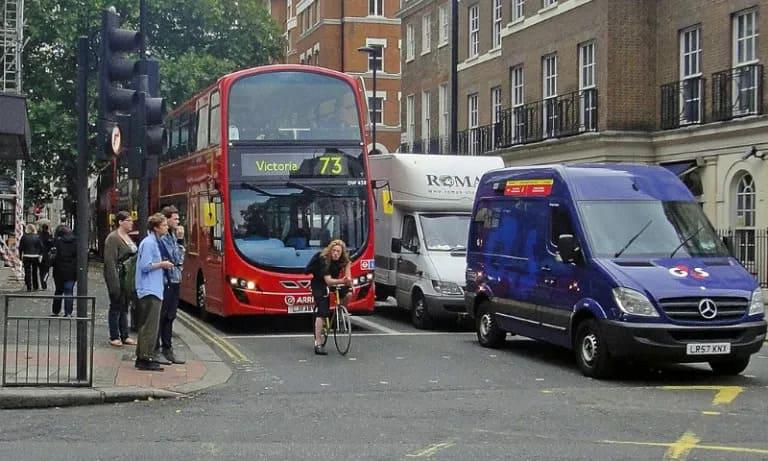

In [ ]:
from PIL import Image
import numpy as np

image = Image.open("detect.jpg")
image_np = np.array(image)
input_tensor = tf.convert_to_tensor(np.expand_dims(image_np, 0), dtype=tf.uint8)
image

In [ ]:
detection = model(input_tensor)


In [ ]:
detection['detection_scores']

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[0.7329862 , 0.61361706, 0.5495555 , 0.5411455 , 0.49572596,
        0.43924373, 0.38463068, 0.38308862, 0.38255113, 0.33180535,
        0.3142916 , 0.29162136, 0.28357378, 0.26935697, 0.26810828,
        0.26262495, 0.26167557, 0.24575084, 0.24062978, 0.23171467,
        0.21922544, 0.21820123, 0.21575613, 0.21500498, 0.214081  ,
        0.21370506, 0.2100582 , 0.20735635, 0.2035068 , 0.20075125,
        0.19822127, 0.19398563, 0.19372377, 0.18962604, 0.18816388,
        0.18766132, 0.18480317, 0.18239191, 0.18134226, 0.1809496 ,
        0.18030612, 0.1801948 , 0.17871447, 0.17462803, 0.17031358,
        0.16973817, 0.16547717, 0.16085775, 0.16019014, 0.1584916 ,
        0.15846628, 0.15588997, 0.15324819, 0.1526673 , 0.15169875,
        0.15080567, 0.14999834, 0.14954807, 0.14907241, 0.14825048,
        0.14811763, 0.14701927, 0.14418578, 0.14261201, 0.14125061,
        0.14106573, 0.13888493, 0.13798793, 0.1366114 , 0.13650802